<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/Pron%C3%B3stico_de_instrumentos_financieros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **🧩 Parte 1: Recolección de datos históricos**

Obtendremos:

*   El S&P 500 (símbolo ^GSPC).
*   Ethereum (símbolo ETH-USD).


Usaremos yfinance, una librería muy práctica para descargar datos financieros directamente desde Yahoo Finance.

In [2]:
import yfinance as yf
import pandas as pd
import datetime

# Fechas
start_date = "2015-01-01"
end_date = "2025-05-23"  # Último dato permitido

# Descarga de datos
# Se usan los precios de cierre diarios del índice S&P 500 y la criptomoneda
# Ethereum (ETH) desde 2015 hasta mayo de 2025, usando yfinance.
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
eth = yf.download("ETH-USD", start=start_date, end=end_date)

# Guardar solo las columnas necesarias
sp500 = sp500[['Close']].rename(columns={'Close': 'S&P500_Close'})
eth = eth[['Close']].rename(columns={'Close': 'ETH_Close'})

# Combinar en un solo DataFrame si lo necesitas
combined_df = pd.concat([sp500, eth], axis=1)

# Ver un fragmento
print(combined_df.tail())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price      S&P500_Close    ETH_Close
Ticker            ^GSPC      ETH-USD
Date                                
2025-05-17          NaN  2475.754395
2025-05-18          NaN  2498.233643
2025-05-19  5963.600098  2529.166748
2025-05-20  5940.459961          NaN
2025-05-21          NaN  2548.963135


## **🧩 Parte 2: Preprocesamiento**
En el siguiente paso, prepararemos los datos para alimentar la red LSTM:

Normalización (MinMaxScaler).

Ventanas de entrada/salida para predicción multihorizonte

División de entrenamiento/prueba.



In [3]:
# 📦 Instalación de librerías
!pip install yfinance
!pip install tensorflow scikit-learn

In [4]:
# 🧹 Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


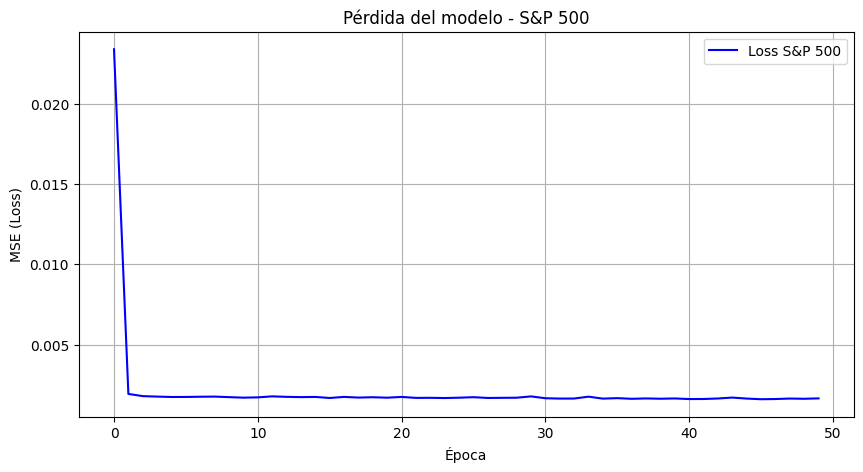

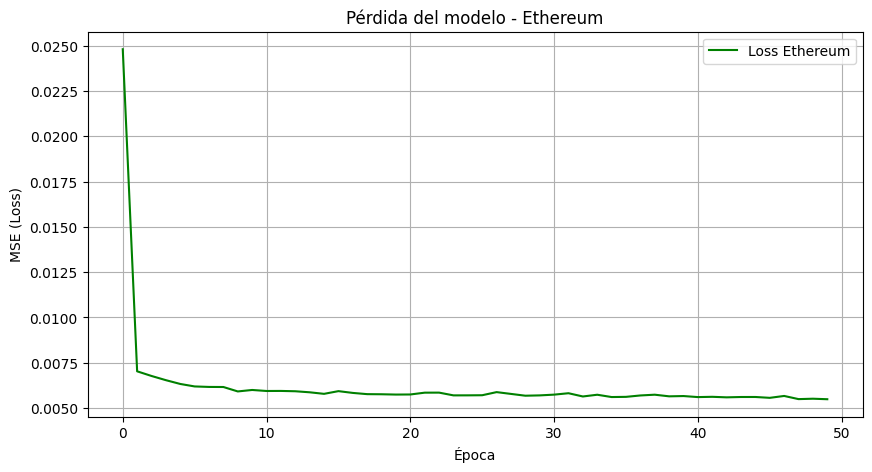

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
🔮 Predicción S&P 500 al 23 de junio de 2025: 5883.92 USD
🔮 Predicción Ethereum al 23 de junio de 2025: 2848.36 USD


In [5]:
# 🗓 Fechas
start_date = "2015-01-01"
end_date = "2025-05-17"  # Último día hábil real disponible

# 🏦 Descargar datos
sp500 = yf.download("^GSPC", start=start_date, end=end_date)[['Close']]
eth = yf.download("ETH-USD", start=start_date, end=end_date)[['Close']]
sp500.columns = ['S&P500_Close']
eth.columns = ['ETH_Close']

# ⚙️ Función para preparar datos
# Se escala la serie con MinMaxScaler para mejorar el entrenamiento de la
# red neuronal. También se preparan las ventanas de datos con 21 días de
# entrada para predecir el precio 21 días después.
def preparar_datos(df, col, window_size=21, pred_offset=21):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[col]])

    X, y = [], []
    for i in range(window_size, len(scaled) - pred_offset):
        X.append(scaled[i - window_size:i])
        y.append(scaled[i + pred_offset][0])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# ⚙️ Función para construir y entrenar la LSTM
# Se entrena una red neuronal LSTM para cada activo. Estas redes son
# buenas con series temporales porque "recuerdan" patrones pasados.
def entrenar_lstm(X, y, units=50, lr=0.001, epochs=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
    history = model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)
    return model, history

# 🧪 Preparar y entrenar para S&P500
X_sp, y_sp, scaler_sp = preparar_datos(sp500, 'S&P500_Close')
model_sp, history_sp = entrenar_lstm(X_sp, y_sp)

# 🧪 Preparar y entrenar para Ethereum
X_eth, y_eth, scaler_eth = preparar_datos(eth, 'ETH_Close')
model_eth, history_eth = entrenar_lstm(X_eth, y_eth)


#Se muestran las curvas de pérdida (error) del modelo a lo largo de las
# épocas para ambos activos. Ayuda a ver si el modelo aprendió correctamente.
# 📈 Gráfica del entrenamiento S&P 500
plt.figure(figsize=(10, 5))
plt.plot(history_sp.history['loss'], label='Loss S&P 500', color='blue')
plt.title('Pérdida del modelo - S&P 500')
plt.xlabel('Época')
plt.ylabel('MSE (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# 📈 Gráfica del entrenamiento Ethereum
plt.figure(figsize=(10, 5))
plt.plot(history_eth.history['loss'], label='Loss Ethereum', color='green')
plt.title('Pérdida del modelo - Ethereum')
plt.xlabel('Época')
plt.ylabel('MSE (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# 📊 Función para hacer predicción final
# Con los últimos 21 días reales, se hace una única predicción para
# el 23 de junio de 2025 para ambos activos.
def hacer_prediccion(df, col, scaler, model, window_size=21):
    ultimos_datos = df[-window_size:][[col]].values
    ultimos_datos_scaled = scaler.transform(ultimos_datos)
    entrada = np.array([ultimos_datos_scaled])
    pred_scaled = model.predict(entrada)
    pred = scaler.inverse_transform(pred_scaled)
    return pred[0][0]

# 🎯 Predicciones finales
pred_sp500 = hacer_prediccion(sp500, 'S&P500_Close', scaler_sp, model_sp)
pred_eth = hacer_prediccion(eth, 'ETH_Close', scaler_eth, model_eth)

# 📢 Mostrar resultados
print(f"🔮 Predicción S&P 500 al 23 de junio de 2025: {pred_sp500:.2f} USD")
print(f"🔮 Predicción Ethereum al 23 de junio de 2025: {pred_eth:.2f} USD")

# **Gráfica para S&P 500 (histórico + predicción)**

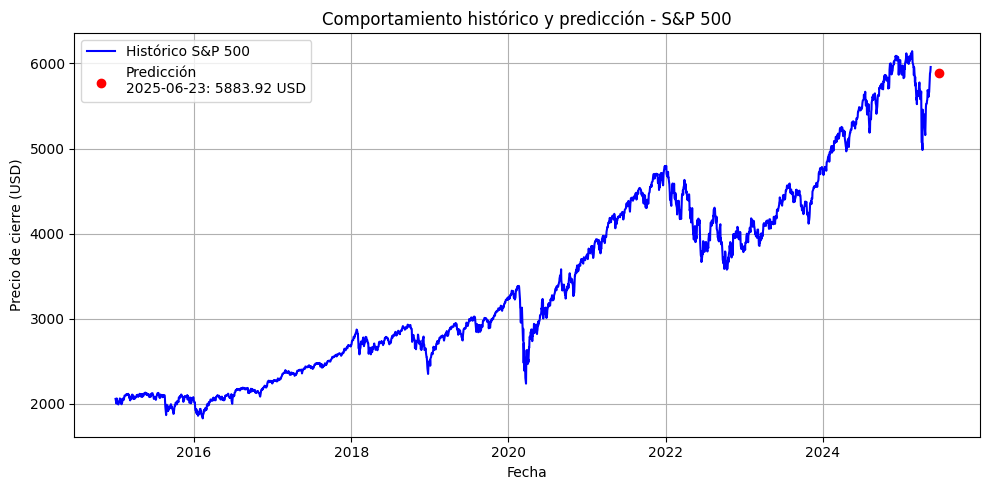

In [6]:
# 📅 Fecha futura a predecir
import pandas as pd
date_pred = pd.to_datetime('2025-06-23')

# 🧾 Generar gráfica de precios históricos + predicción S&P 500
plt.figure(figsize=(10, 5))
plt.plot(sp500.index, sp500['S&P500_Close'], label='Histórico S&P 500', color='blue')
plt.scatter(date_pred, pred_sp500, color='red', label=f'Predicción\n{date_pred.date()}: {pred_sp500:.2f} USD', zorder=5)
plt.title('Comportamiento histórico y predicción - S&P 500')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Gráfica para Ethereum (histórico + predicción)**

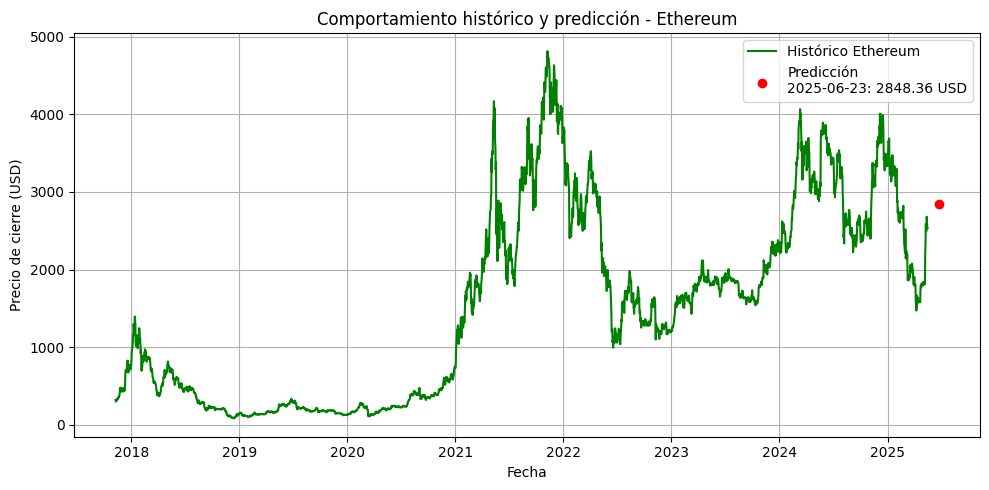

In [7]:
# 🧾 Generar gráfica de precios históricos + predicción Ethereum
plt.figure(figsize=(10, 5))
plt.plot(eth.index, eth['ETH_Close'], label='Histórico Ethereum', color='green')
plt.scatter(date_pred, pred_eth, color='red', label=f'Predicción\n{date_pred.date()}: {pred_eth:.2f} USD', zorder=5)
plt.title('Comportamiento histórico y predicción - Ethereum')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
